# Random Forest Adult Income

## Introduction
This script guides us through data preparation, feature engineering, and the training and optimisation of a Random Forest model to predict income levels using the UCI Adult Income dataset. It evaluates the model's performance, tunes the depth parameter, and finally, interprets feature importance for model insights.

The full dataset can be found here: https://archive.ics.uci.edu/dataset/20/census+income

## Libraries and Model Imports

We begin by importing essential libraries like pandas, numpy, matplotlib, and seaborn for data manipulation, statistical operations, and visualisation. Several models and metrics from sklearn are also imported to facilitate data splitting, model training, and performance evaluation.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Data Loading and Column Naming

The Adult Income dataset is loaded with columns manually named according to the dataset documentation. This dataset is structured to analyse individuals’ income levels based on features like age, workclass, and education.

In [56]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num',
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv('adult.data', header=None, names = col_names)

## Data Exploration and Cleaning

- Distribution of Income: We first check the proportion of each income level in the dataset to understand the class balance.
- Data Cleaning: Extra whitespace in object-type columns is removed to standardise text entries and improve consistency.

In [59]:
#Distribution of income
print(df.income.value_counts(normalize=True))
print(df.info())

#Clean columns by stripping extra whitespace for columns of type "object"
for col in df.select_dtypes(['object']).columns:
  df[col] = df[col].str.strip()

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


## Feature Selection and Dummy Variable Creation

- Feature Selection: A subset of columns (age, capital-gain, capital-loss, hours-per-week, sex, and race) is chosen for initial modelling.
- Dummy Variables: To handle categorical variables (sex and race), we use pd.get_dummies to convert them into binary variables, excluding one category to avoid collinearity.
- Target Variable: The income column is mapped to binary values: 0 for <=50K and 1 for >50K.

In [62]:
#Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

X = pd.get_dummies(df[feature_cols], drop_first=True)
#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = df['income'].map({
  "<=50K": 0,
  ">50K": 1
})

## Data Splitting

We split the data into training and testing sets (80% training, 20% testing) to train the model on a portion of the data and evaluate it on unseen data.

In [65]:
#Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, test_size=.20)

## Random Forest Model Training

- Baseline Model: A Random Forest Classifier is instantiated with default parameters, fitted to the training data, and evaluated using test data accuracy.
- Output: An initial accuracy score is printed, serving as a baseline to compare against optimised models.

In [68]:
#Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

print(f'Initial default RF forest score: {rf.score(X_test, y_test)}')

Initial default RF forest score: 0.8094580070627975


## Hyperparameter Tuning

- Depth Tuning: The max_depth parameter, controlling tree depth, is tested across a range from 1 to 25. The model is retrained for each depth, with accuracy recorded for both training and test sets.
- Best Depth Selection: We find the depth achieving the highest accuracy on the test set, marking it as the best model depth.
- Visualisation: A plot shows training and test accuracies across depths, illustrating model performance as tree complexity varies.

In [70]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train = []
accuracy_test = []
depths = np.arange(1,26,1)
for depth in depths:
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(X_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(X_train)))

## Feature Importance Evaluation:

We retrain the Random Forest with the best max_depth found and calculate feature importances. This indicates which features most significantly affect the model’s predictions, allowing us to interpret the model’s decisions.

Best accuracy: 0.8209734377399048
Best Depth: 14


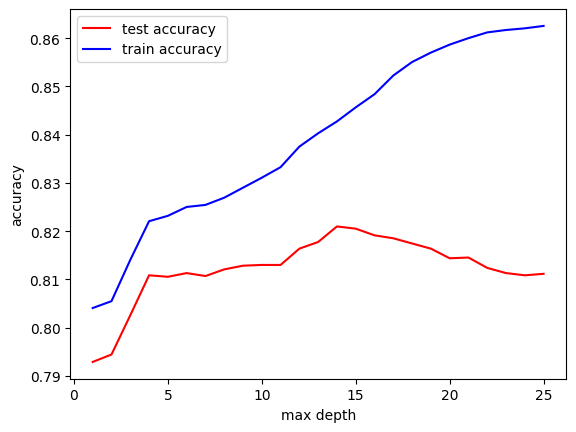

Top 5 random forest features:
          feature  importance
1    capital-gain    0.355011
0             age    0.259970
2    capital-loss    0.144690
3  hours-per-week    0.141772
4        sex_Male    0.076163


In [73]:
#Find the best accuracy and at what depth that occurs
best_accuracy = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]

print(f'Best accuracy: {best_accuracy}')
print(f'Best Depth: {best_depth}')

#Plot the accuracy scores for the test and train set over the range of depth values
plt.plot(depths, accuracy_test, c='red')
plt.plot(depths, accuracy_train, c='blue')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

#Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

## Feature Engineering

Two new features are created: education_bin, categorising education levels, and native-country. We update the feature set to include these new features and recreate the training and testing splits.

In [75]:
#Create two new features, based on education and native country
df['education_bin'] =  pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']
#Use these two new additional features and recreate X and test/train split
X = pd.get_dummies(df[feature_cols], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

#Find the best max depth now with the additional two features
np.random.seed(0)

## Model Training with New Features

The hyperparameter tuning process is repeated with the updated feature set to find the optimal max_depth. The best depth and its corresponding accuracy are printed, and the model is retrained with the additional features for improved performance.

The highest accuracy on the test is achieved when depth: 9
The highest accuracy on the test set is: 84.431%


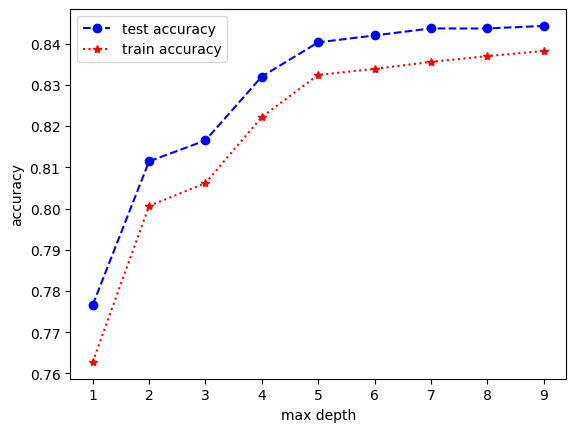

In [77]:
accuracy_train=[]
accuracy_test = []
depths = range(1,10)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    

#Save the best model and print the two features with the new feature set
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')
plt.figure(2)
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

## Final Model Evaluation and Feature Importances

The Random Forest model is retrained with the updated feature set and the best max_depth, with feature importances printed for interpretation. The top features provide insights into which factors most influence income predictions in the model’s current setup.

In [79]:
# Retrain with better model
best_rf = RandomForestClassifier(max_depth=9)
best_rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
          feature  importance
0             age    0.326777
3  hours-per-week    0.276717
1    capital-gain    0.166229
2    capital-loss    0.109842
4        sex_Male    0.043077
